In [1]:
# Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%%capture
!git clone https://github.com/jupyter/nbconvert.git
!cd nbconvert

!pip install -e .

!apt-get install pandoc

!apt-get update
!apt-get install inkscape
!add-apt-repository --yes universe
!add-apt-repository --yes ppa:inkscape.dev/stable
!apt-get update
!apt-get install -y inkscape

!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic texlive-latex-extra -y


!pip install numpy==1.26.0
!pip install sklearn
!pip install pyBibX
!pip install prettytable
!pip install bibtexparser
!pip install pygam
!pip install typing-extensions

In [3]:
# Data Manipulation
import pandas as pd
import numpy as np
import re

# Machine Learning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats and Models
from math import sqrt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from pygam import LinearGAM, s, f

# BibTeX
import textwrap
import bibtexparser
from bibtexparser.bparser import BibTexParser
from bibtexparser.customization import convert_to_unicode
from pyBibX.base import pbx_probe

# Google Colab
from google.colab import files
from google.colab import data_table

# Miscellaneous
from prettytable import PrettyTable

In [4]:
# Download .bib files
# Screened References
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/savedrecs.bib

# Journal Specific Bib Files
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_AND_BEHAVIORAL_MEDICINE.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_OPEN.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_REPORT.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_RESEARCH.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_REVIEW.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/IMPLEMENTATION_SCIENCE.bib
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/PILOT_AND_FEASIBILITY_STUDIES.bib
#!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/PSYCHOLOGY_AND_HEALTH.bib
#!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/PSYCHOLOGY_HEALTH_AND_MEDICINE.bib


# Download Web of Science Journal Impact.csv file
!wget https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Journal%20CSV%20Files/Merged%20CSV%20File/journal_impact.csv


--2024-02-06 00:27:05--  https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/savedrecs.bib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3988510 (3.8M) [text/plain]
Saving to: ‘savedrecs.bib.3’

savedrecs.bib.3     100%[===================>]   3.80M  --.-KB/s    in 0.07s   

2024-02-06 00:27:05 (56.1 MB/s) - ‘savedrecs.bib.3’ saved [3988510/3988510]

--2024-02-06 00:27:05--  https://raw.githubusercontent.com/5H5KN5/SIT723/main/Impact/Bib/Journals/HEALTH_PSYCHOLOGY_AND_BEHAVIORAL_MEDICINE.bib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting resp

In [5]:
class BibTeXParser:
    def __init__(self, bib_file_path):
        self.bib_file_path = bib_file_path

    def load_bib_file(self, database='wos', del_duplicated=True):
        """
        Loads a .bib file and processes it with pbx_probe.

        Parameters:
        - database (str): The database to use for processing.
        - del_duplicated (bool): Flag to delete duplicated entries.

        Returns:
        - Processed .bib file data.
        """
        return pbx_probe(file_bib=self.bib_file_path, db=database, del_duplicated=del_duplicated)

    def parse_bib_file(self, bib_file_path, max_authors=20):
        """
        Parses a BibTeX file to extract information about articles, including authors, titles, years, and citation counts.

        Parameters:
        - bib_file_path (str): Path to the BibTeX file.
        - max_authors (int): Maximum number of authors to extract per article.

        Returns:
        - DataFrame: A pandas DataFrame with article details.
        """

        # Read the content of the BibTeX file
        with open(bib_file_path, 'r', encoding='utf-8') as file:
            bib_content = file.read()

        # Regular expressions for extracting relevant fields
        author_re = re.compile(r'Author\s*=\s*{(.*?)}', re.DOTALL)
        title_re = re.compile(r'Title\s*=\s*{(.+?)}', re.DOTALL)
        year_re = re.compile(r'Year\s*=\s*{(.+?)}', re.DOTALL)
        times_cited_re = re.compile(r'Times-Cited\s*=\s*{(.+?)}', re.DOTALL)

        # Splitting the content into individual records
        records = bib_content.split('@article')[1:]  # skip the first split as it's before the first record

        # Initialize lists to hold extracted data
        data = []

        for record in records:
            # Extracting data using regular expressions
            author_match = author_re.search(record)
            title = title_re.search(record)
            year = year_re.search(record)
            times_cited_count = times_cited_re.search(record)

            # Remove "\n" characters and split authors by "and"
            authors_text = author_match.group(1).replace('\n', '').strip()
            authors = [author.strip() for author in re.split(r'\s+and\s+', authors_text)] if author_match else [''] * max_authors
            authors += [''] * (max_authors - len(authors))  # Fill empty strings if authors are less than max_authors

            # Create a record list
            record_data = authors[:max_authors] + [
                title.group(1) if title else '',
                year.group(1) if year else '',
                times_cited_count.group(1) if times_cited_count else ''
            ]

            # Append the record to the data list
            data.append(record_data)

        # Column names
        author_columns = [f'Author_{i+1}' for i in range(max_authors)]
        columns = author_columns + ['Title', 'Year', 'Times-Cited']

        # Creating a DataFrame
        df = pd.DataFrame(data, columns=columns)

        return df

    def filter_bib_entries(self, start_year=2018, end_year=2023):
        """
        Filters BibTeX entries based on a specified year range.

        Parameters:
        - file_path (str): Path to the BibTeX file.b
        - start_year (int): Start year for filtering.
        - end_year (int): End year for filtering.

        Returns:
        - str: Filtered BibTeX entries as a single string.
        """
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        # Splitting the content into entries
        entries = re.split(r'(?=@article)', content)

        filtered_entries = []
        for entry in entries:
            # Searching for the year in each entry
            year_match = re.search(r'\bYear\s*=\s*{(\d{4})},', entry)
            if year_match:
                year = int(year_match.group(1))
                if start_year <= year <= end_year:
                    filtered_entries.append(entry)

        # Joining the filtered entries back into a single string
        return '\n'.join(filtered_entries)

    def extract_bibtex_data(self):
        """
        Extracts data from a BibTeX file into a DataFrame.

        Parameters:
        - file_path (str): Path to the BibTeX file.

        Returns:
        - DataFrame: Extracted data as a DataFrame.
        """
        with open(file_path) as bibtex_file:
            bib_database = bibtexparser.load(bibtex_file)

        data = []
        for entry in bib_database.entries:
            # Concatenating multi-line titles into a single string
            title = entry.get('Title', 'No Title Available').replace('\n', ' ').replace('{', '').replace('}', '').strip()
            times_cited = entry.get('times-cited', 'Not Cited').strip('{}')

            data.append({'Title': title, 'Times Cited': times_cited})

        return pd.DataFrame(data)

class CitationAnalysis:
    def __init__(self, bib_data):
        self.bib_data = bib_data

    def merge_journal_data(self, spc_df, spd_df, journal_name_mapping):
        """
        Merge data from two DataFrames and process journal-related data.

        Parameters:
            spc_df (pd.DataFrame): DataFrame containing special data.
            spd_df (pd.DataFrame): DataFrame containing specific data.
            journal_name_mapping (dict): Mapping dictionary to replace values in the "Journal" column.

        Returns:
            pd.DataFrame: Merged and processed DataFrame.
        """
        # Merge for Journals
        journal_merged_df = pd.merge(spc_df, spd_df, on='Journal', how='left')
        journal_merged_df = journal_merged_df[['Journal', 'Citations', 'Publications']].rename(columns={'Publications': 'Documents'})

        # Replace the values in the "Journal" column using the mapping
        journal_merged_df['Journal'] = journal_merged_df['Journal'].replace(journal_name_mapping)

        # Rename the "Documents" column to "Publication"
        journal_merged_df = journal_merged_df.rename(columns={'Documents': 'Publication'})

        # Reorder the columns
        journal_merged_df = journal_merged_df[['Journal', 'Publication', 'Citations']]

        # Sort the DataFrame by the "Citations" column in descending order
        journal_merged_df = journal_merged_df.sort_values(by='Citations', ascending=False)

        # Reset the index after sorting
        journal_merged_df = journal_merged_df.reset_index(drop=True)

        return journal_merged_df

    def process_journal_impact(self, jif_file, year_to_filter):
        """
        Process journal impact data from a CSV file for a specific year.

        Parameters:
            jif_file (str): Path to the CSV file containing journal impact data.
            year_to_filter (int): The year to filter the data by.

        Returns:
            pd.DataFrame: Processed journal impact data for the specified year.
        """
        # Read the journal impact data from the CSV file
        journal_impact_df = pd.read_csv(jif_file)

        # Filter by year
        journal_impact_df = journal_impact_df.loc[journal_impact_df['Year'] == year_to_filter]

        # List of columns to drop
        columns_to_drop = ['Year', 'Total Citations', 'JIF without self cites', '5 Year Impact Factor', 'Immediacy Index', 'Citable items', 'Percent of articles in Citable items', 'Average JIF Percentile']

        # Drop the specified columns
        journal_impact_df = journal_impact_df.drop(columns=columns_to_drop)

        # Rename columns
        journal_impact_df = journal_impact_df.rename(columns={'Journal impact factor': 'Journal Impact Factor', 'Journal Name': 'Journal'})

        return journal_impact_df

    def merge_dataframes(self, journal_merged_df, journal_impact_df):
        """
        Merge two DataFrames based on the "Journal" column.

        Parameters:
            journal_merged_df (pd.DataFrame): Merged and processed journal data.
            journal_impact_df (pd.DataFrame): Processed journal impact data.

        Returns:
            pd.DataFrame: Merged DataFrame with journal data and impact data.
        """
        # Merge the two DataFrames on the "Journal" column
        merged_df = pd.merge(journal_merged_df, journal_impact_df, on='Journal', how='left')

        return merged_df

    def plot_and_save_data(self, statistic, topn=None, size_x=15, size_y=10, rename_columns=None, numeric_columns=None, csv_path=None):
        """
        Adjusted method to handle both numeric and string data.
        """
        # Generate the plot
        self.bib_data.plot_bars(statistic=statistic, topn=topn, size_x=size_x, size_y=size_y)

        # Retrieve and process the data
        data = pd.DataFrame(self.bib_data.ask_gpt_bp)

        if rename_columns:
            data.rename(columns=rename_columns, inplace=True)

        # Convert specified columns to numeric, if possible
        if numeric_columns:
            for col in numeric_columns:
                data[col] = pd.to_numeric(data[col], errors='coerce')

        # Save to CSV if a path is provided
        if csv_path:
            data.to_csv(csv_path, index=False)

        return data

    def extract_cpy(self):
        """
        Extracts and processes citation per year (cpy) data.
        """
        return self.plot_and_save_data(statistic='cpy', csv_path='cpy.csv')

    def extract_dpy(self):
        """
        Extracts and processes documents per year (dpy) data.
        """
        return self.plot_and_save_data(statistic='dpy', topn=605, csv_path='dpy.csv')

    def extract_apc(self):
        """
        Extracts and processes authors per citation (apc) data.
        """
        return self.plot_and_save_data(statistic='apc', topn=3634, rename_columns={'Citations': 'Authors', 'Authors': 'Citations'}, csv_path='apc.csv')

    def extract_apd(self):
        """
        Extracts and processes authors per document (apd) data.
        """
        return self.plot_and_save_data(statistic='apd', topn=3634, rename_columns={'Documents': 'Authors', 'Authors': 'Publications'}, csv_path='apd.csv')

    def extract_aph(self):
        """
        Extracts and processes authors per H-Index (aph) data.
        """
        return self.plot_and_save_data(statistic='aph', topn=3634, rename_columns={'H-Index': 'Authors', 'Authors': 'H-Index'}, csv_path='aph.csv')

    def extract_spc(self):
        """
        Extracts and processes sources per citation (spc) data.
        """
        journal_full_names = {
                'implement. sci.': 'Implementation Science',
                'health psychol.': 'Health Psychology',
                'health psychol. rev.': 'Health Psychology Review',
                'psychol. health': 'Psychology & Health',
                'pilot feasibility stud.': 'Pilot and Feasibility Studies',
                'psychol. health med.': 'Psychology Health & Medicine',
                'health psychol. behav. med.': 'Health Psychology and Behavioral Medicine',
                'health psychol. open': 'Health Psychology Open',
                'health psychol. rep.': 'Health Psychology Report',
                'health psychol. res.': 'Health Psychology Research'
        }
        return self.plot_and_save_data(statistic='spc', topn=10, rename_columns={'Citations': 'Journal', 'Sources': 'Citations'}, csv_path='spc.csv')

    def extract_spd(self):
        """
        Extracts and processes sources per document (spd) data.
        """
        journal_name_mapping = {
                'implement. sci.': 'Implementation Science',
                'health psychol.': 'Health Psychology',
                'health psychol. rev.': 'Health Psychology Review',
                'psychol. health': 'Psychology & Health',
                'pilot feasibility stud.': 'Pilot and Feasibility Studies',
                'psychol. health med.': 'Psychology Health & Medicine',
                'health psychol. behav. med.': 'Health Psychology and Behavioral Medicine',
                'health psychol. open': 'Health Psychology Open',
                'health psychol. rep.': 'Health Psychology Report',
                'health psychol. res.': 'Health Psychology Research'
        }
        return self.plot_and_save_data(statistic='spd', topn=10, rename_columns={'Documents': 'Journal', 'Sources': 'Publications'}, csv_path='spd.csv')

    def extract_cpd(self):
        """
        Extracts and processes countries per document (cpd) data.
        """
        return self.plot_and_save_data(statistic='cpd', csv_path='cpd.csv')

    def extract_cpc(self):
        """
        Extracts and processes countries per citation (cpc) data.
        """
        return self.plot_and_save_data(statistic='cpc', csv_path='cpc.csv')

    def prepare_citations_dataframe(self, citations):
        """
        Filters and prepares a citations DataFrame by converting year and citation count columns to numeric

        Parameters:
        - citations (DataFrame): The citations DataFrame.
        - current_year (int): The current year to filter from.

        Returns:
        - DataFrame: Filtered citations DataFrame.
        """
        # Convert 'Year' and 'Times-Cited' columns to numeric
        citations['Year'] = pd.to_numeric(citations['Year'], errors='coerce')
        citations['Times-Cited'] = pd.to_numeric(citations['Times-Cited'], errors='coerce')

        return citations

    def expand_authors(self, citations_filtered, author_columns):
        """
        Expands a DataFrame of citations where each row contains multiple author columns into a DataFrame
        where each row represents a single author's citation.

        Parameters:
        - citations_filtered (DataFrame): The filtered citations DataFrame.
        - author_columns (list): List of columns in the DataFrame that contain author names.

        Returns:
        - DataFrame: Expanded citations DataFrame with one author per row.
        """
        return pd.concat(
            [citations_filtered[[col, 'Title', 'Year', 'Times-Cited']].rename(columns={col: 'Author'})
            for col in author_columns],
            ignore_index=True
        ).query("Author != ''")

    def calculate_citations_and_publications(self, expanded_authors):
        """
        Calculates the total number of citations and publications per author.

        Parameters:
        - expanded_authors (DataFrame): The expanded authors DataFrame.

        Returns:
        - Tuple(DataFrame, DataFrame): Two DataFrames with publications count and citations count per author.
        """
        # Group by Author and Title, then sum citations
        citation_sum = expanded_authors.groupby(['Author', 'Title'])['Times-Cited'].sum().reset_index()

        # Count unique documents and calculate total citations per author
        publications_count = expanded_authors.groupby('Author')['Title'].nunique()
        author_citations = citation_sum.groupby('Author')['Times-Cited'].sum()

        return publications_count, author_citations

    def merge_author_stats(self, expanded_authors, publications_count, author_citations):
        """
        Merges the expanded authors DataFrame with publications count and total citations DataFrames.

        Parameters:
        - expanded_authors (DataFrame): The expanded authors DataFrame.
        - publications_count (DataFrame): DataFrame with publications count per author.
        - author_citations (DataFrame): DataFrame with total citations per author.

        Returns:
        - DataFrame: Merged DataFrame.
        """
        # Convert to DataFrames and rename columns
        publications_count_df = publications_count.reset_index().rename(columns={'Title': 'Publication Count'})
        author_citations_df = author_citations.reset_index().rename(columns={'Times-Cited': 'Total Citations'})

        # Merge with expanded authors dataframe
        merged_df = expanded_authors.merge(publications_count_df, on='Author', how='left') \
                                    .merge(author_citations_df, on='Author', how='left')
            # Drop 'Times-Cited' and 'Publication Count' columns
        merged_df.drop(['Times-Cited', 'Publication Count'], axis=1, inplace=True)

        # Rename 'Author' to 'First Author' and 'Total Citations' to 'Citations'
        merged_df.rename(columns={'Author': 'First Author', 'Total Citations': 'Citations'}, inplace=True)

        # Remove duplicates to ensure each author is represented once
        return merged_df.drop_duplicates(subset='First Author')

class GAMAnalysis:
    def __init__(self, X, y, title, xlabel, ylabel):
        self.X = X
        self.y = y
        self.title = title
        self.xlabel = xlabel  # Add xlabel attribute
        self.ylabel = ylabel  # Add ylabel attribute

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

    def fit_model(self, n_splines_range=[5, 10, 15], lambda_range=np.logspace(-3, 3, 7)):
        best_aic = np.inf
        best_model = None

        for n_splines in n_splines_range:
            for lam in lambda_range:
                model = LinearGAM(s(0, n_splines=n_splines, lam=lam)).fit(self.X_train, self.y_train)
                aic = model.statistics_['AIC']

                if aic < best_aic:
                    best_aic = aic
                    best_model = model

        self.model = best_model
        print(f"{self.title} - Best Model AIC: {best_aic}")
        # Print the summary of the best model
        self.model.summary()
        self.calculate_rmse()

    def plot_results(self):
        plt.figure(figsize=(10, 5))
        plt.scatter(self.X, self.y, color='black', label='Data')
        X_range = np.linspace(self.X.min(), self.X.max(), 100).reshape(-1, 1)
        predictions = self.model.predict(X_range)
        conf_ints = self.model.confidence_intervals(X_range, width=.95)
        plt.plot(X_range, predictions, color='royalblue', label='GAM Prediction')
        plt.fill_between(X_range.flatten(), conf_ints[:, 0], conf_ints[:, 1], color='royalblue', alpha=0.2, label='95% Confidence Interval')
        plt.title(self.title)
        plt.xlabel(self.xlabel)  # Use dynamic xlabel
        plt.ylabel(self.ylabel)  # Use dynamic ylabel
        min_y = min(predictions.min(), self.y.min())
        padding = (self.y.max() - min_y) * 0.05
        plt.ylim(bottom=min(0, min_y - padding), top=self.y.max() + padding)
        plt.legend()
        plt.show()

    def calculate_rmse(self):
        predictions = self.model.predict(self.X_test)
        rmse = sqrt(mean_squared_error(self.y_test, predictions))
        print(f"{self.title} - \nRMSE: {rmse}")

In [6]:
file_name = 'savedrecs.bib'
bib_file_path = 'savedrecs.bib'
file_path = 'savedrecs.bib'
jif = 'journal_impact.csv'

In [7]:
# Create an instance of BibTeXParser
bib_parser = BibTeXParser(file_path)

# Load and process the BibTeX file
bibfile = bib_parser.load_bib_file(database='wos', del_duplicated=True)

# Extract BibTeX data into a DataFrame
df = bib_parser.extract_bibtex_data()

A Total of 414 Documents were Found ( 414 Documents and 0 Duplicates )

Article = 347
Article in Press = 2
Correction = 1
Editorial Material = 8
Proceedings Paper = 1
Review = 52
Review; Early Access = 3


In [8]:
# # For Journal Impact Analysis
# journal_files = [
#     "HEALTH_PSYCHOLOGY_AND_BEHAVIORAL_MEDICINE.bib",
#     "HEALTH_PSYCHOLOGY_OPEN.bib",
#     "HEALTH_PSYCHOLOGY_REPORT.bib",
#     "HEALTH_PSYCHOLOGY_RESEARCH.bib",
#     "HEALTH_PSYCHOLOGY_REVIEW.bib",
#     "HEALTH_PSYCHOLOGY.bib",
#     "IMPLEMENTATION_SCIENCE.bib",
#     "PILOT_AND_FEASIBILITY_STUDIES.bib",
# ]
# name_mapping = {
#     "HEALTH_PSYCHOLOGY_AND_BEHAVIORAL_MEDICINE.bib": "Health Psychology And Behavioral Medicine",
#     "HEALTH_PSYCHOLOGY_OPEN.bib": "Health Psychology Open",
#     "HEALTH_PSYCHOLOGY_REPORT.bib": "Health Psychology Report",
#     "HEALTH_PSYCHOLOGY_RESEARCH.bib": "Health Psychology Research",
#     "HEALTH_PSYCHOLOGY_REVIEW.bib": "Health Psychology Review",
#     "HEALTH_PSYCHOLOGY.bib": "Health Psychology",
#     "IMPLEMENTATION_SCIENCE.bib": "Implementation Science",
#     "PILOT_AND_FEASIBILITY_STUDIES.bib": "Pilot And Feasibility Studies",
#     #"PSYCHOLOGY_AND_HEALTH.bib": "Psychology & Health",
#     #"PSYCHOLOGY_HEALTH_AND_MEDICINE.bib": "Psychology, Health & Medicine"
# }

# # Dictionary to store loaded files
# loaded_bibs = {}

# # Create an instance of BibTeXParser for each journal file and load each file
# for file in journal_files:
#     print(f"\nProcessing file: {file}")
#     bib_parser = BibTeXParser(file)
#     loaded_bibs[file] = bib_parser.load_bib_file()

In [9]:
%%capture
# Extract Citation Data
# Create an instance of the CitationAnalysis class
citation_analysis = CitationAnalysis(bibfile)

# Extract information for each statistic and store it in DataFrames
cpy_df = citation_analysis.extract_cpy() # Citations per Year
dpy_df = citation_analysis.extract_dpy() # Documents per Year
spd_df = citation_analysis.extract_spd() # Sources per Documents
spc_df = citation_analysis.extract_spc() # Sources per Citations
apd_df = citation_analysis.extract_apd() # Authors per Documents
apc_df = citation_analysis.extract_apc() # Authors per Citations
aph_df = citation_analysis.extract_aph() # Authors per H-Index
cpd_df = citation_analysis.extract_cpd() # Countries per Documents
cpc_df = citation_analysis.extract_cpc() # Countries per Citations

In [10]:
# # Sort and display the top entries for each DataFrame
# print("Citations per Year:\n", cpy_df.sort_values(by='Citations', ascending=False).head(10))
# print("\nDocuments per Year:\n", dpy_df.sort_values(by='Documents', ascending=False).head(10))
# print("\nSources per Documents:\n", spd_df.sort_values(by='Publications', ascending=False).head(10))
# print("\nSources per Citations:\n", spc_df.sort_values(by='Citations', ascending=False).head(10))
# print("\nAuthors per Documents:\n", apd_df.sort_values(by='Publications', ascending=False).head(10))
# print("\nAuthors per Citations:\n", apc_df.sort_values(by='Citations', ascending=False).head(10))
# print("\nAuthors per H-Index:\n", aph_df.sort_values(by='H-Index', ascending=False).head(10))
# print("\nCountries per Documents:\n", cpd_df.sort_values(by='Countries', ascending=False).head(10))
# print("\nCountries per Citations:\n", cpc_df.sort_values(by='Countries', ascending=False).head(10))

In [11]:
cpd_df

,Documents,Countries
0,United Kingdom,891
1,United States of America,730
2,UNKNOW,253
3,Australia,213
4,Canada,166
5,Netherlands,142
6,Ireland,105
7,Germany,63
8,South Africa,31
9,Belgium,29


In [12]:
bib_parser = BibTeXParser(bib_file_path)
articles_df = bib_parser.parse_bib_file(bib_file_path)

articles_df

# Initialize CitationAnalysis instance
citation_analysis = CitationAnalysis(bib_data=articles_df)

# Prepare the citations DataFrame
prepared_df = citation_analysis.prepare_citations_dataframe(articles_df)

# Expand authors from the prepared DataFrame
author_columns = [f'Author_{i+1}' for i in range(20)]
expanded_authors_df = citation_analysis.expand_authors(prepared_df, author_columns)

# Calculate citations and publications
publications_count, author_citations = citation_analysis.calculate_citations_and_publications(expanded_authors_df)

# Merge author stats
cpdoc_df = citation_analysis.merge_author_stats(expanded_authors_df, publications_count, author_citations)

# Sort the DataFrame by the number of citations
cpdoc_df = cpdoc_df.sort_values(by='Citations', ascending=False)

# Drop duplicate entries
cpdoc_df = cpdoc_df.drop_duplicates(subset=['Title'])

# Save to CSV
cpdoc_df.to_csv('/content/drive/My Drive/Colab Notebooks/SIT723/Data/Results/cpdoc.csv', index=False)

# Display the first few rows of the final merged DataFrame
cpdoc_df

,First Author,Title,Year,Citations
231,"Michie, Susan",Optimising the value of the evidence generated...,2017,9416
67,"Damschroder, Laura J.",Conceptualizing outcomes for use with the Cons...,2022,9151
1517,"Kirsh, Susan R.",Fostering implementation of health services re...,2009,6858
762,"O'Connor, Denise",Validation of the theoretical domains framewor...,2012,3826
1183,"Grimshaw, Jeremy M.",Specifying and reporting complex behaviour cha...,2009,2111
...,...,...,...,...
1852,"Rixon, L.",Evaluating Palin Stammering Therapy for School...,2022,0
1853,"Fridline, Judy",Michigan Model for Health™ Learning to Enhance...,2022,0
2075,"ten Hoor, Gill",How to improve the diet of toddlers? The feasi...,2022,0
116,"Kent, William",A review of stress management interventions fo...,2021,0


In [13]:
# Create an instance of the CitationAnalysis class
citation_analysis = CitationAnalysis(bibfile)

# Define the journal_name_mapping
journal_name_mapping = {
    'implement. sci.': 'Implementation Science',
    'health psychol.': 'Health Psychology',
    'health psychol. rev.': 'Health Psychology Review',
    'psychol. health': 'Psychology and Health',
    'pilot feasibility stud.': 'Pilot and Feasibility Studies',
    'psychol. health med.': 'Psychology, Health & Medicine',
    'health psychol. behav. med.': 'Health Psychology and Behavioral Medicine',
    'health psychol. open': 'Health Psychology Open',
    'health psychol. rep.': 'Health Psychology Reports',
    'health psychol. res.': 'Health Psychology Research'
}

journal_merged_df = citation_analysis.merge_journal_data(spc_df, spd_df, journal_name_mapping)

# Process journal impact data for a specific year
year_to_filter = 2022
journal_impact_df = citation_analysis.process_journal_impact(jif, year_to_filter)

# Merge the DataFrames
journal_data = citation_analysis.merge_dataframes(journal_merged_df, journal_impact_df)

# Display the merged DataFrame
print("Merged DataFrame:")
journal_data

Merged DataFrame:


,Journal,Publication,Citations,Journal Impact Factor
0,Implementation Science,122,26655,7.2
1,Health Psychology Review,38,3904,9.8
2,Health Psychology,57,3786,4.2
3,Psychology and Health,29,1829,3.3
4,Pilot and Feasibility Studies,126,707,1.7
5,"Psychology, Health & Medicine",18,230,3.8
6,Health Psychology and Behavioral Medicine,19,44,2.7
7,Health Psychology Open,2,10,2.9
8,Health Psychology Reports,2,8,2.0
9,Health Psychology Research,1,1,2.0


In [14]:
# Top 20 Authors by Citation, Publication and H-Index
# Merge the dataframes apc_df, apd_df, and aph_df on 'Authors'
author_stats_df = pd.merge(apc_df, apd_df, on='Authors', suffixes=('_Citations', '_Publications'))
author_stats_df = pd.merge(author_stats_df, aph_df, on='Authors')

# Rename columns for clarity
author_stats_df.rename(columns={
    'Citations': 'Citations',
    'Documents': 'Publications',
    'H-Index': 'H-Index'
}, inplace=True)

# Convert Author Names to Sentence Case
author_stats_df['Authors'] = author_stats_df['Authors'].str.title()
sorted_author_stats_df = author_stats_df.sort_values(by='Citations', ascending=False)

author_stats_df

,Authors,Citations,Publications,H-Index
0,"Michie, Susan",9416,17,16
1,"Damschroder, Laura J.",9151,5,4
2,"Lowery, Julie C.",6858,1,0
3,"Kirsh, Susan R.",6858,1,0
4,"Keith, Rosalind E.",6858,1,0
...,...,...,...,...
2538,"Agans, Jennifer P.",0,1,0
2539,"Afifi, Tracie O.",0,1,0
2540,"Abrahams, Zulfa",0,1,0
2541,"Abotsie, Gabriel",0,1,0


Publications per Year Model - Best Model AIC: 213.81793162821683
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.5521
Link Function:                     IdentityLink Log Likelihood:                                  -101.3569
Number of Samples:                           24 AIC:                                              213.8179
                                                AICc:                                             217.9878
                                                GCV:                                                40.289
                                                Scale:                                             26.8203
                                                Pseudo R-Squared:              

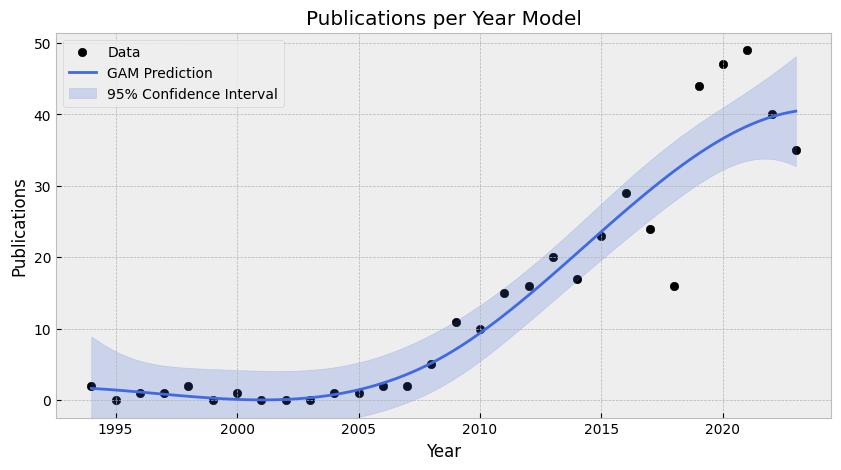

Citations per Year Model - Best Model AIC: 678.2383281581973
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       5.675
Link Function:                     IdentityLink Log Likelihood:                                  -332.4441
Number of Samples:                           23 AIC:                                              678.2383
                                                AICc:                                             684.9243
                                                GCV:                                          1328263.6678
                                                Scale:                                          755513.699
                                                Pseudo R-Squared:                  

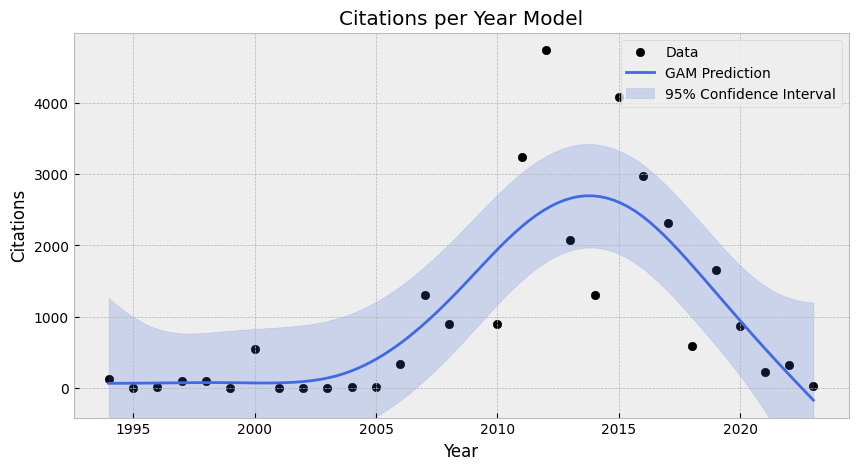

Publications vs Citations Model - Best Model AIC: 684.505998643655
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.5563
Link Function:                     IdentityLink Log Likelihood:                                  -337.6967
Number of Samples:                           23 AIC:                                               684.506
                                                AICc:                                             687.4086
                                                GCV:                                          1307262.5094
                                                Scale:                                         949345.2604
                                                Pseudo R-Squared:            

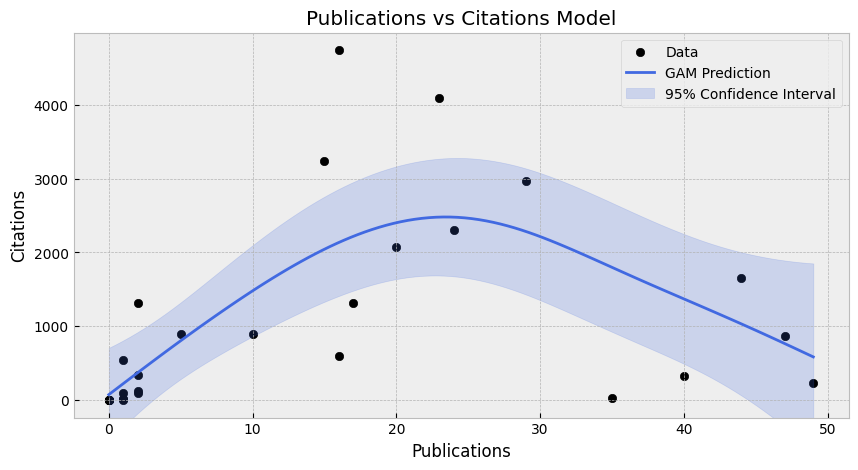

In [15]:
# Define X and y for "Documents per Year" using the extracted data
X_dpy = dpy_df[['Year']].values
y_dpy = dpy_df['Documents'].values

# Remove the year with the highest outlier in citations from both datasets
outlier_year = cpy_df.loc[cpy_df['Citations'].idxmax()]['Year']
cpy_df_no_outlier = cpy_df[cpy_df['Year'] != outlier_year]
dpy_df_no_outlier = dpy_df[dpy_df['Year'] != outlier_year]

# Redefine X and y for the "Documents vs Citations" model without the outlier
X_dyp_df_no_outlier = dpy_df_no_outlier[['Documents']].values
y_cpy_df_no_outlier = cpy_df_no_outlier['Citations'].values

# Redefine X and y for "Citations per Year" without the outlier
X_cpy_no_outlier = cpy_df_no_outlier[['Year']].values
y_cpy_no_outlier = cpy_df_no_outlier['Citations'].values

# Analyze "Documents per Year"
gam_analysis_dpy = GAMAnalysis(X_dpy, y_dpy, "Publications per Year Model", "Year", "Publications")
gam_analysis_dpy.split_data()
gam_analysis_dpy.fit_model()
gam_analysis_dpy.plot_results()

# Analyze "Citations per Year" without the outlier
gam_analysis_cpy_no_outlier = GAMAnalysis(X_cpy_no_outlier, y_cpy_no_outlier, "Citations per Year Model", "Year", "Citations")
gam_analysis_cpy_no_outlier.split_data()
gam_analysis_cpy_no_outlier.fit_model()
gam_analysis_cpy_no_outlier.plot_results()

# Analyze "Documents vs Citations" without the outlier
gam_analysis_no_outlier = GAMAnalysis(X_dyp_df_no_outlier, y_cpy_df_no_outlier, "Publications vs Citations Model", "Publications", "Citations")
gam_analysis_no_outlier.split_data()
gam_analysis_no_outlier.fit_model()
gam_analysis_no_outlier.plot_results()

In [16]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/SIT723/Impact Analysis.ipynb" --output-dir "/content/drive/MyDrive/Colab Notebooks/SIT723/"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/SIT723/Impact Analysis.ipynb to pdf
[NbConvertApp] Writing 109470 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 87887 bytes to /content/drive/MyDrive/Colab Notebooks/SIT723/Impact Analysis.pdf
